**Author:** Regina Hoo

**Institution:** Wellcome Sanger institute

**April, 2023**

---

## 25-10-2023
## Malaria parasites single cell DEG: Comparing pf_b versus pf_iv for early trophozoite stage

In [1]:
library(limma)
library(scuttle)
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)
library(Seurat)
library(edgeR)
library(reshape2)
library(magrittr)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats

Warning message:
“package ‘matrixStats’ was built under R version 4.0.5”

Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps

In [2]:
anndata <- readRDS('./output/rna4_annotate_ET_F.rds')
anndata

An object of class Seurat 
5515 features across 142251 samples within 1 assay 
Active assay: originalexp (5515 features, 0 variable features)

In [3]:
Idents(anndata)= anndata$stage_1

In [4]:
head(Idents(anndata))

Pla_HDBR11345021_AAACCCAAGCGATGCA Pla_HDBR11345021_AAACCCAAGGCACGAT 
                            pf_iv                             pf_iv 
Pla_HDBR11345021_AAACCCACAAGCCCAC Pla_HDBR11345021_AAACCCACAATAACGA 
                            pf_iv                             pf_iv 
Pla_HDBR11345021_AAACCCACAGCGTTTA Pla_HDBR11345021_AAACCCACATCTGGGC 
                            pf_iv                             pf_iv 
Levels: pf_b pf_iv pf_nb

# Early trophozoites

In [5]:
ET= subset(x = anndata, idents = c("pf_iv", "pf_b"))
Idents(object = ET) <- "infection"

In [6]:
#fixxing levels
#ET$idc_new.stage_1 = factor(ET$idc_new.stage_1, levels = c("2_early_trophozoite-pf_iv", "2_early_trophozoite-pf_nb", "2_early_trophozoite-pf_b"))

ET$idc_new<- factor(ET$idc_new, levels = c("2_early_trophozoite"))

#The levels for the infection should follow this order to ensure that positive Fold changes correspond to increases in pf_b
ET$stage_1<- factor(ET$stage_1, levels = c("pf_iv","pf_b"))
ET$classification = paste(ET$idc_new, ET$stage_1, sep='-') # split celltype by disease status

In [7]:
# estimate % cells expressing a gene in each class
plot <- DotPlot(object = ET, features = rownames(ET), group.by = 'classification')
plot$data$value = plot$data$pct.exp
percent_mat = acast(plot$data, features.plot ~ id)

Warning message:
“Scaling data with a low number of groups may produce misleading results”


In [8]:
head(percent_mat)

,2_early_trophozoite-pf_b,2_early_trophozoite-pf_iv
PF3D7-1400100,0.82423105,1.123099559
RIF,0.03685586,0.022069642
RIF-1,0.03350533,0.009808730
RIF-2,0.02010320,0.017165277
RIF-3,0.14407291,0.063756744
RIF-4,0.02010320,0.004904365


In [9]:
table(ET[["stage_1"]] )


pf_iv  pf_b 
40780 29846 

In [10]:
anndata_sce <- as.SingleCellExperiment(ET)

In [11]:
anndata_sce

class: SingleCellExperiment 
dim: 5515 70626 
metadata(0):
assays(2): counts logcounts
rownames(5515): PF3D7-1400100 RIF ... RIF-181 VAR-79
rowData names(0):
colnames(70626): Pla_HDBR11345021_AAACCCAAGCGATGCA
  Pla_HDBR11345021_AAACCCAAGGCACGAT ...
  Pla_HDBR13007973_TTTGTTGTCGCCAACG Pla_HDBR13007973_TTTGTTGTCTCGAGTA
colData names(39): orig.ident nCount_originalexp ... classification
  ident
reducedDimNames(0):
altExpNames(0):

### Prepare the pseudobulk count matrix:

In [12]:
# generate 3 metacells for each donor-celltype combination. This is for pseudobulk.
n=3
anndata_sce$random_seed = sample(1:n, size = ncol(anndata_sce), replace = T)
anndata_sce$metacell_id = paste( colData(anndata_sce)$stage_1, 
                                colData(anndata_sce)$idc_new, 
                                colData(anndata_sce)$p_batch, 
                                colData(anndata_sce)$random_seed, 
                                sep='-')

## aggregateAcrossCells here it is only aggregated by celltype, genotype
## this creates the pseudobulk counts
summed <- aggregateAcrossCells(anndata_sce, id=colData(anndata_sce)[,c("metacell_id")])

##have a look at the counts
counts(summed)[1:3,]

#have a look at the colData of our new object summed, can you see Group and 
# metacell_id are there
# colData(summed)
table(summed$stage_1)
table(summed$classification)


,pf_b-2_early_trophozoite-p_batch1-1,pf_b-2_early_trophozoite-p_batch1-2,pf_b-2_early_trophozoite-p_batch1-3,pf_b-2_early_trophozoite-p_batch2-1,pf_b-2_early_trophozoite-p_batch2-2,pf_b-2_early_trophozoite-p_batch2-3,pf_b-2_early_trophozoite-p_batch7-1,pf_b-2_early_trophozoite-p_batch7-2,pf_b-2_early_trophozoite-p_batch7-3,pf_iv-2_early_trophozoite-p_batch1-1,pf_iv-2_early_trophozoite-p_batch1-2,pf_iv-2_early_trophozoite-p_batch1-3,pf_iv-2_early_trophozoite-p_batch2-1,pf_iv-2_early_trophozoite-p_batch2-2,pf_iv-2_early_trophozoite-p_batch2-3,pf_iv-2_early_trophozoite-p_batch7-1,pf_iv-2_early_trophozoite-p_batch7-2,pf_iv-2_early_trophozoite-p_batch7-3
PF3D7-1400100,8,4,9,24,26,13,54,54,60,23,20,37,31,37,35,108,88,113
RIF,0,0,0,1,0,2,4,1,3,0,1,2,0,0,0,1,1,4
RIF-1,0,0,0,3,1,1,2,4,2,1,0,0,0,0,1,0,0,2



pf_iv  pf_b 
    9     9 


 2_early_trophozoite-pf_b 2_early_trophozoite-pf_iv 
                        9                         9 

In [13]:
summed

class: SingleCellExperiment 
dim: 5515 18 
metadata(0):
assays(1): counts
rownames(5515): PF3D7-1400100 RIF ... RIF-181 VAR-79
rowData names(0):
colnames(18): pf_b-2_early_trophozoite-p_batch1-1
  pf_b-2_early_trophozoite-p_batch1-2 ...
  pf_iv-2_early_trophozoite-p_batch7-2
  pf_iv-2_early_trophozoite-p_batch7-3
colData names(43): orig.ident nCount_originalexp ... ids ncells
reducedDimNames(0):
altExpNames(0):

In [14]:
summed$stage_1<- factor(summed$stage_1, levels = c("pf_iv","pf_b"))

In [15]:
table(summed$stage_1)


pf_iv  pf_b 
    9     9 

In [16]:
y <- DGEList(counts(summed), samples=colData(summed)$metacell_id)

In [17]:
keep <- filterByExpr(y, group=summed$p_batch, min.prop = 0.2)

In [18]:
genes20percent = rownames(percent_mat)[ apply(percent_mat[, unique(summed$classification) ], 1, max) > 20 ] # get genes with > 20% expressed cells in the celltypeOf_interest
    keep <- keep & names(keep) %in% genes20percent
    y <- y[ keep ,]

In [19]:
y <- edgeR::calcNormFactors(y)

In [20]:
summary(keep)

   Mode   FALSE    TRUE 
logical    3141    2374 

In [21]:
design <- model.matrix(~summed$p_batch+summed$stage_1)

# stimate dispersion
y <- estimateDisp(y,design)

# Have a look
head(design)

,(Intercept),summed$p_batchp_batch2,summed$p_batchp_batch7,summed$stage_1pf_b
1,1,0,0,1
2,1,0,0,1
3,1,0,0,1
4,1,1,0,1
5,1,1,0,1
6,1,1,0,1


In [22]:
# (4) Do limma DEG
fit <- glmQLFit(y, design)
qlf <- glmQLFTest(fit)
topTags(qlf)

,logFC,logCPM,F,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DJ1,-1.0380310,8.440514,1354.1791,2.107009e-17,5.002039e-14
INO1,-0.8693159,7.909585,891.9665,6.511004e-16,7.728562e-13
RFC3-1,-1.2821875,6.223439,746.1425,2.803040e-15,2.218139e-12
CWC22-1,0.6365082,8.950355,579.4259,2.195921e-14,1.134296e-11
ASF1,-1.0642308,6.524222,573.4391,2.388998e-14,1.134296e-11
PF3D7-0810000,-1.0239468,7.159627,482.7954,9.615507e-14,3.804535e-11
PF3D7-0716300,-0.6525673,9.956149,467.3448,1.250090e-13,4.239590e-11
PF3D7-0105800,-0.9805008,6.978377,451.4980,1.650762e-13,4.898637e-11
PCNA2,-1.1442682,6.617081,439.9933,2.032064e-13,5.360132e-11


In [23]:
# Adjust P values using bonferroni and BH
limma_de = qlf$table
limma_de$bonferroni = p.adjust(limma_de$PValue, "bonferroni")
limma_de$p_val_adj = p.adjust(limma_de$PValue, "BH")

In [24]:
# order table by P-value
limma_de= limma_de[ order(limma_de$p_val_adj, decreasing = TRUE), ]
#limma_de <- order(limma_de$p.adjust, decreasing = FALSE)
#imma_de = limma_de.sort_values('p.adjust', ascending = TRUE)

In [25]:
##  Saving the DEG matrice
write.table(limma_de,'./output/1_DEGs_limma_SC_MAL_ET_Final.tsv',sep = '\t',quote = FALSE,row.names = TRUE,col.names = NA)


### Checking the stats of the latest tested celltype

In [26]:
#colData(summed_celltype)$metacell_id

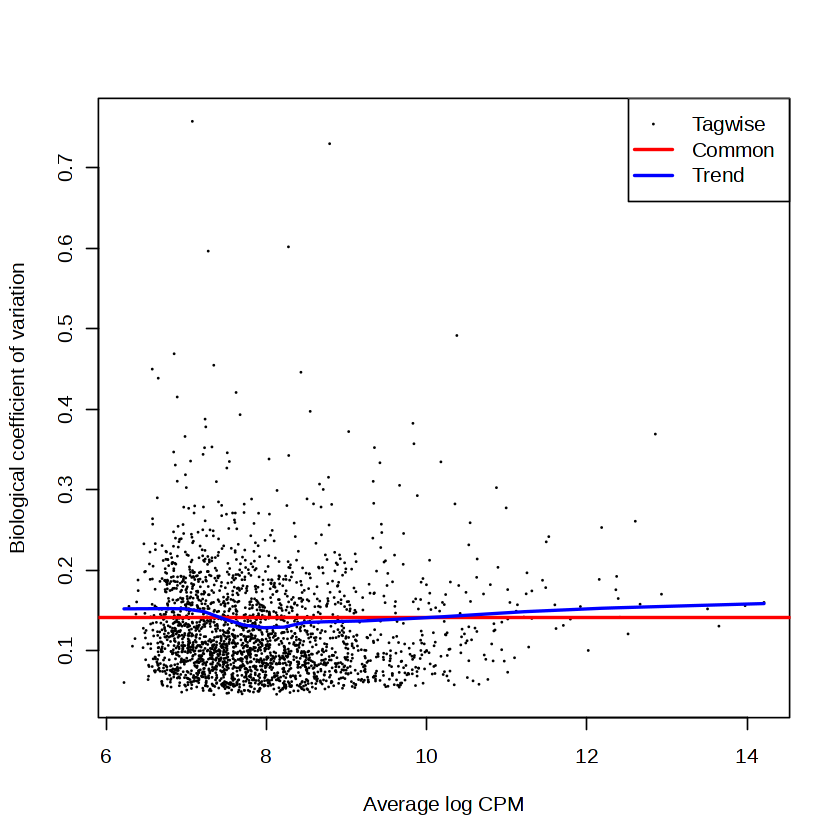

In [27]:
plotBCV(y)

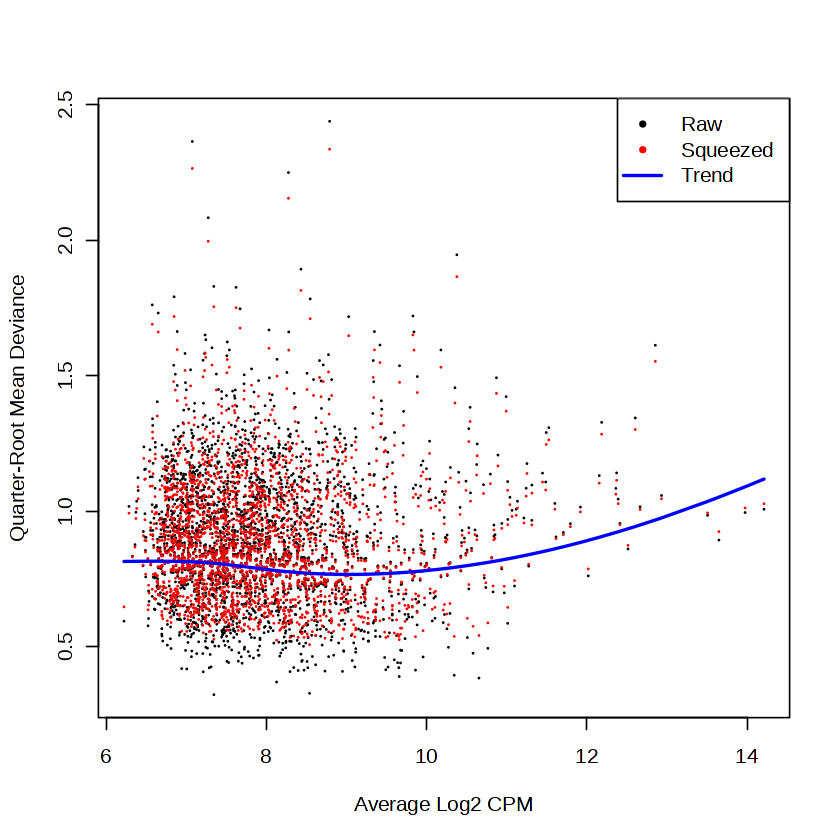

In [28]:
plotQLDisp(fit)

In [29]:
o <- order(qlf$table$PValue)
cpm(y)[o[1:20],]

,pf_b-2_early_trophozoite-p_batch1-1,pf_b-2_early_trophozoite-p_batch1-2,pf_b-2_early_trophozoite-p_batch1-3,pf_b-2_early_trophozoite-p_batch2-1,pf_b-2_early_trophozoite-p_batch2-2,pf_b-2_early_trophozoite-p_batch2-3,pf_b-2_early_trophozoite-p_batch7-1,pf_b-2_early_trophozoite-p_batch7-2,pf_b-2_early_trophozoite-p_batch7-3,pf_iv-2_early_trophozoite-p_batch1-1,pf_iv-2_early_trophozoite-p_batch1-2,pf_iv-2_early_trophozoite-p_batch1-3,pf_iv-2_early_trophozoite-p_batch2-1,pf_iv-2_early_trophozoite-p_batch2-2,pf_iv-2_early_trophozoite-p_batch2-3,pf_iv-2_early_trophozoite-p_batch7-1,pf_iv-2_early_trophozoite-p_batch7-2,pf_iv-2_early_trophozoite-p_batch7-3
DJ1,219.26899,224.00294,210.59917,296.61484,300.54785,304.36939,158.37413,162.11465,169.46230,434.89242,435.80193,430.52670,624.6809,642.71890,595.4047,340.50808,341.51057,348.29598
INO1,213.92097,205.37914,212.44249,157.77828,154.82768,146.46347,138.01952,146.37536,147.51677,394.53852,384.31784,395.08509,289.5181,277.35127,290.2007,254.37357,256.40149,249.46131
RFC3-1,43.75656,35.69562,45.16131,41.00570,45.75440,40.36067,43.21273,45.74886,43.14170,94.85145,100.89638,97.75193,105.2003,97.32791,108.3115,108.27506,110.06074,110.53286
CWC22-1,429.78668,432.48605,432.71908,582.61400,569.86995,575.86772,785.88399,789.69246,813.91148,272.88337,277.30966,279.87372,385.5894,387.75970,353.5023,499.71612,512.11936,510.32085
ASF1,77.78944,81.22047,78.80188,61.61263,64.83680,57.62838,34.28718,41.65664,38.85964,159.33857,160.35688,155.56672,137.1516,123.71064,125.3700,81.81322,83.15592,84.73686
PF3D7-0810000,96.75062,87.94573,77.41939,83.26031,81.31706,94.24425,101.22882,111.85386,105.23149,181.69147,183.45738,185.36276,185.8393,167.38626,177.1622,206.74225,206.25402,211.01727
PF3D7-0716300,842.55691,886.69987,890.78379,860.49527,884.72960,860.88895,559.15320,581.72402,592.74338,1401.60576,1430.67754,1391.52754,1299.1362,1254.62099,1336.9374,927.57255,943.03597,927.50615
PF3D7-0105800,97.72299,103.98289,95.85258,78.26469,76.54646,80.09721,72.81944,79.32600,76.11352,176.74614,174.96303,175.84894,172.1459,168.93819,178.1898,148.96318,145.51065,151.67648
PCNA2,59.31445,56.38873,60.82952,80.55435,67.87264,61.99732,48.54630,53.09386,53.20453,146.97524,144.50765,148.24839,147.5847,141.66864,149.6219,106.76989,107.76577,111.33273
P92,153.14797,159.33697,158.52541,63.27783,60.28305,58.04447,27.86514,33.05250,26.44169,344.88740,349.09734,360.06167,201.0542,184.90085,183.9445,72.29667,65.67511,70.58905


In [30]:
summary(decideTests(qlf))

       summed$stage_1pf_b
Down                  759
NotSig                939
Up                    676

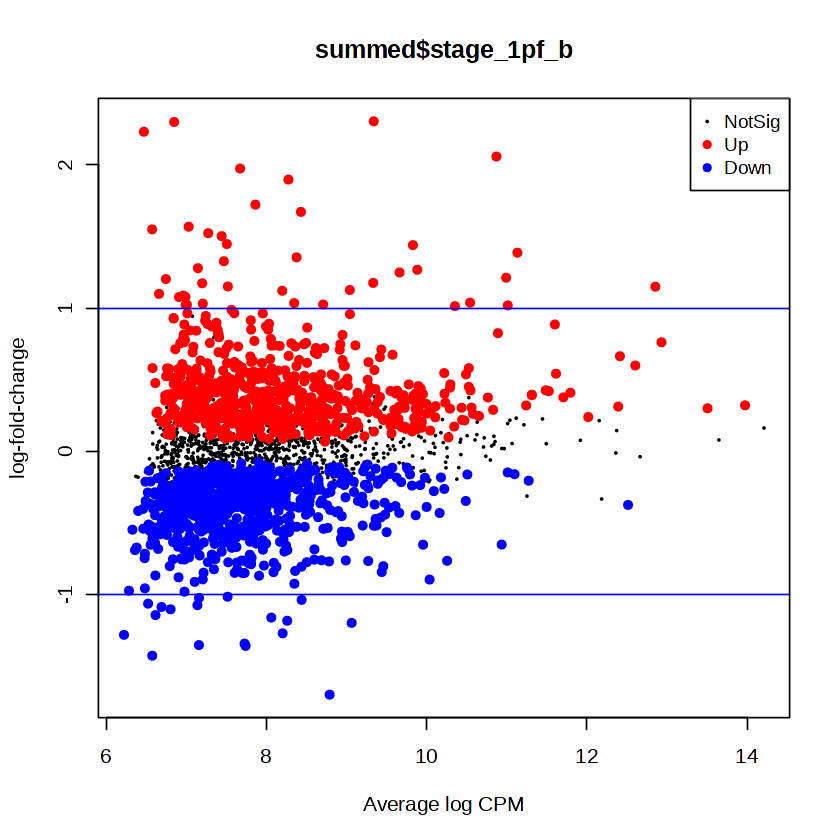

In [31]:
plotMD(qlf)
abline(h=c(-1, 1), col="blue")

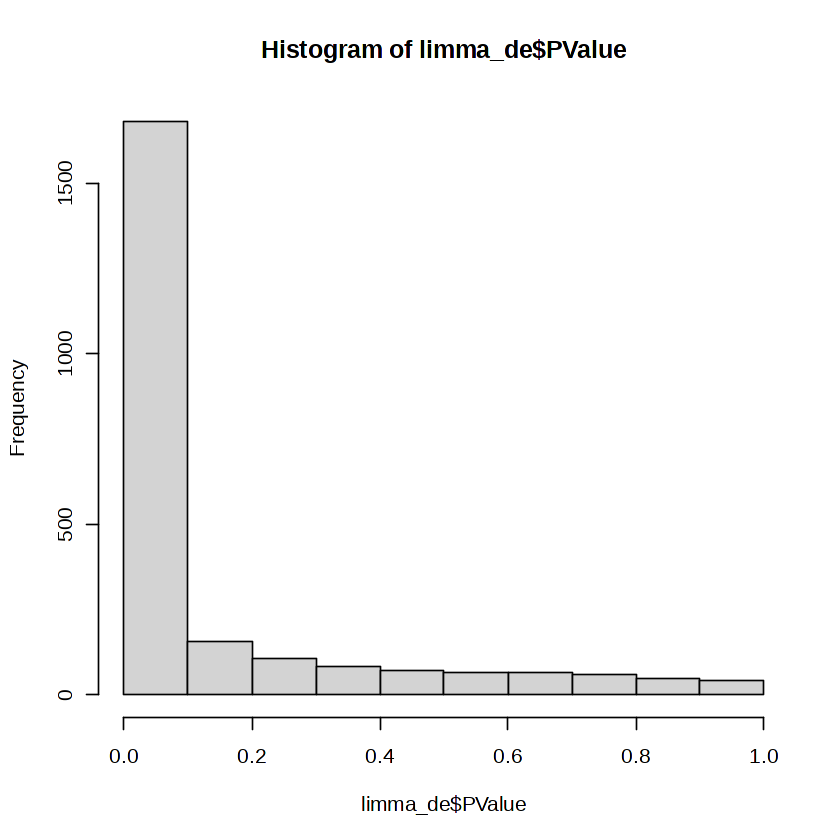

In [32]:
limma_de = qlf$table
limma_de$p.adjust = p.adjust(limma_de$PValue, "bonferroni")
limma_de$BH = p.adjust(limma_de$PValue, "BH")

hist(limma_de$PValue)

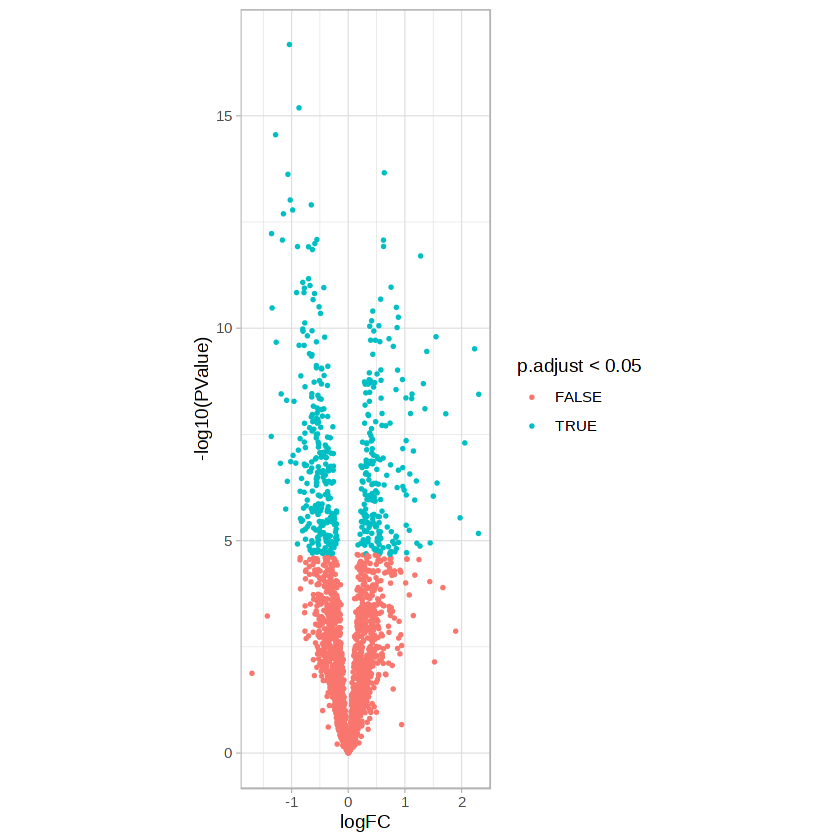

In [33]:
library(ggplot2, warn.conflicts = FALSE)
ggplot(limma_de, aes(x = logFC, y = - log10(PValue))) +
  geom_point(aes(color = p.adjust < 0.05), size = 0.5) + 
    theme_light()  + 
    coord_fixed(ratio = 0.75)

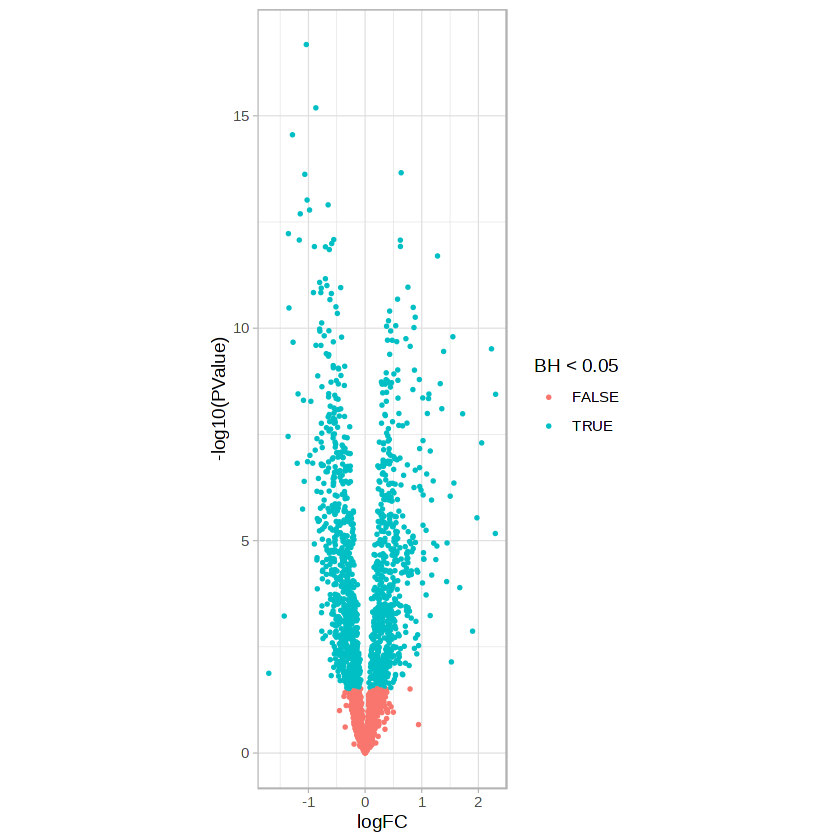

In [34]:
ggplot(limma_de, aes(x = logFC, y = - log10(PValue))) +
  geom_point(aes(color = BH < 0.05), size = 0.5) + 
    theme_light()  + 
    coord_fixed(ratio = 0.75)